# UCI dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import statsmodels.api as sm

In [2]:
#loading data from csv
df = pd.read_csv('forestfires.csv')
df.info

<bound method DataFrame.info of      X  Y month  day  FFMC    DMC     DC   ISI  temp  RH  wind  rain   area
0    7  5   mar  fri  86.2   26.2   94.3   5.1   8.2  51   6.7   0.0   0.00
1    7  4   oct  tue  90.6   35.4  669.1   6.7  18.0  33   0.9   0.0   0.00
2    7  4   oct  sat  90.6   43.7  686.9   6.7  14.6  33   1.3   0.0   0.00
3    8  6   mar  fri  91.7   33.3   77.5   9.0   8.3  97   4.0   0.2   0.00
4    8  6   mar  sun  89.3   51.3  102.2   9.6  11.4  99   1.8   0.0   0.00
..  .. ..   ...  ...   ...    ...    ...   ...   ...  ..   ...   ...    ...
512  4  3   aug  sun  81.6   56.7  665.6   1.9  27.8  32   2.7   0.0   6.44
513  2  4   aug  sun  81.6   56.7  665.6   1.9  21.9  71   5.8   0.0  54.29
514  7  4   aug  sun  81.6   56.7  665.6   1.9  21.2  70   6.7   0.0  11.16
515  1  4   aug  sat  94.4  146.0  614.7  11.3  25.6  42   4.0   0.0   0.00
516  6  3   nov  tue  79.5    3.0  106.7   1.1  11.8  31   4.5   0.0   0.00

[517 rows x 13 columns]>

In [3]:
# function for mean absolute percentage error
def mean_absolute_percentage_error(y_test, y_pred): 
    return np.mean(np.abs((y_test - y_pred) / (y_test+10e-1)) ) * 100

## Encoding Data

In [4]:
# label_encoder object knows how to understand word labels.
label_encoder = preprocessing.LabelEncoder()
 
# Encode labels in column 'species'.
df['month']= label_encoder.fit_transform(df['month'])
df['day']= label_encoder.fit_transform(df['day'])
X = df.iloc[:,:-1].to_numpy()
Y = df.iloc[:,-1].to_numpy()
# df.info


In [5]:
# splitting data for training and testing
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

## Analyzing data

Text(0, 0.5, 'number of fires')

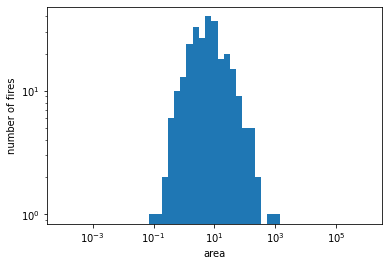

In [6]:
fig = plt.hist(Y,bins=np.logspace(-4,6, 50))
plt.gca().set_yscale('log')
plt.gca().set_xscale('log')
plt.xlabel('area')
plt.ylabel('number of fires')

In [7]:
#Best Features - Univariate statistical selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
import plotly.express as px
import pandas as pd

#apply SelectKBest class to extract top 10 best features
feature_names = ['X','Y','month','day','FFMC','DMC','DC','ISI','temp','RH','wind','rain']
bestfeatures = SelectKBest(score_func=chi2, k=12)
fit = bestfeatures.fit(X,np.array(Y).astype(int))
dfscores = pd.DataFrame(fit.scores_)
df_specs = pd.Series(feature_names).astype(str)
#concat two dataframes for better visualization 
featureScores = pd.concat([df_specs,dfscores],axis=1)
featureScores.columns = ['Feature','Score']  #naming the dataframe columns
print(featureScores.nlargest(12,'Score'))  #print 10 best features
px.bar(featureScores, y='Score', x=feature_names,width=800, height=600)

   Feature        Score
6       DC  5519.298286
5      DMC  2354.025363
9       RH   385.465278
2    month   263.339617
11    rain   230.570175
7      ISI   141.603429
8     temp   134.638938
3      day    75.324026
0        X    65.588459
10    wind    57.498686
1        Y    22.311578
4     FFMC    11.179406


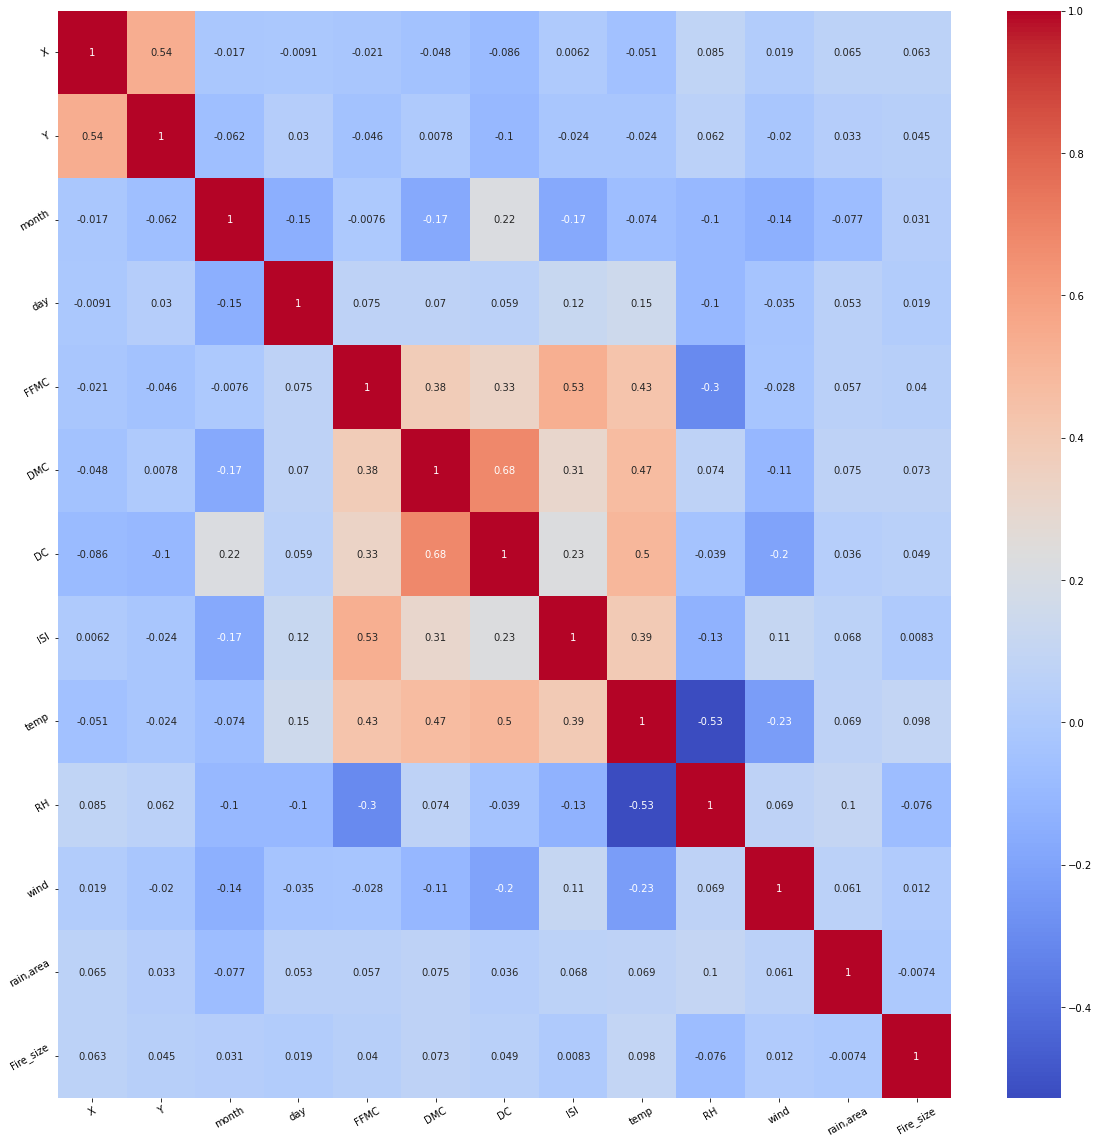

In [8]:
# Best feautres - correlation heatmap
import seaborn as sns
feature_names = ['X','Y','month','day','FFMC','DMC','DC','ISI','temp','RH','wind','rain,area','Fire_size']
data = np.concatenate((X,Y.reshape(-1,1)),axis=1)
corrmat = np.corrcoef(data.T)
plt.figure(figsize=(20,20))
g=sns.heatmap(corrmat,annot=True,cmap="coolwarm")
g.set_xticklabels(feature_names,rotation=30)
g.set_yticklabels(feature_names,rotation=30)
# plt.savefig('corr_UCI.png')
plt.show()


## Linear regression

723.3740639915917 MAPE


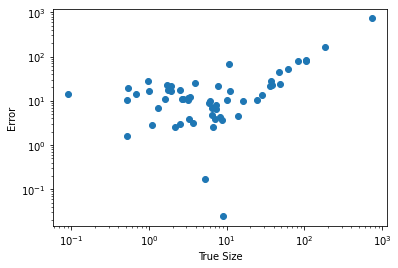

In [9]:
from sklearn.linear_model import LinearRegression

linModel = LinearRegression().fit(x_train, y_train)

linPred = linModel.predict(x_test)

plt.scatter(y_test, abs(linPred - y_test))
plt.xlabel('True Size')
plt.ylabel('Error')
plt.gca().set_xscale("log")
plt.gca().set_yscale("log")
print(mean_absolute_percentage_error(y_test, linPred), 'MAPE')
lin_reg_y_test = y_test
lin_reg_pred = linPred

## SVM Regression

linear 86.01464252307842 MAPE
poly 68.57227466128906 MAPE
rbf 69.69342074197176 MAPE
sigmoid 123.73208493097808 MAPE


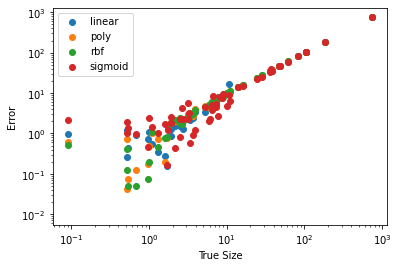

In [10]:
from sklearn.svm import SVR
kernels = ['linear', 'poly', 'rbf', 'sigmoid'];
error_k = [None] * len(y_test)

for k in kernels:
    svmModel = SVR(kernel=k).fit(x_train,y_train)
    svmPredict = svmModel.predict(x_test)
    plt.scatter(y_test, abs(svmPredict - y_test), label = k)
    plt.xlabel('True Size')
    plt.ylabel('Error')
    plt.gca().set_xscale("log")
    plt.gca().set_yscale("log")
    print(k,  mean_absolute_percentage_error(y_test, svmPredict), 'MAPE')
    error = svmPredict - y_test
    error_k = np.c_[error_k, error.T]


plt.legend(kernels)


poly:  67.27463829951901


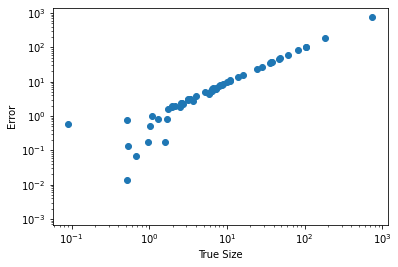

In [11]:
# we removed 2 features with lowest correlation from and fit data on svm with poly kernel
from sklearn.svm import SVR
new_x = np.delete(x_train, 4,1)
new_x = np.delete(new_x, 1,1)
new_x_test = np.delete(x_test, 4,1)
new_x_test = np.delete(new_x_test, 1,1)
svmModel_2 = SVR(kernel='poly').fit(new_x,y_train)
svmPredict = svmModel_2.predict(new_x_test)
plt.scatter(y_test, abs(svmPredict - y_test), label = 'poly')
plt.xlabel('True Size')
plt.ylabel('Error')
plt.gca().set_xscale("log")
plt.gca().set_yscale("log")
print('poly: ', mean_absolute_percentage_error(y_test, svmPredict))

## KNN regression

knnPredict: ( 10 ) : 945.6235525100967 MAPE
knnPredict: ( 60 ) : 771.5240657974887 MAPE
knnPredict: ( 110 ) : 845.4094150014741 MAPE
knnPredict: ( 160 ) : 896.9914042338628 MAPE
knnPredict: ( 210 ) : 800.1771001400347 MAPE


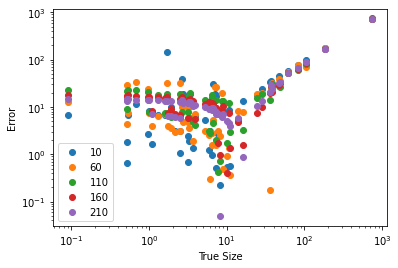

In [12]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score


for i in range(10,211,50):
    knnModel = KNeighborsRegressor(n_neighbors = i).fit(x_train, y_train)
    knnPredict = knnModel.predict(x_test)
    plt.scatter(y_test, abs(knnPredict - y_test))
    plt.xlabel('True Size')
    plt.ylabel('Error')
    plt.gca().set_xscale("log")
    plt.gca().set_yscale("log")
    print("knnPredict: (", i,") :" ,mean_absolute_percentage_error(y_test, knnPredict), 'MAPE')
plt.legend([ _ for _ in range(10,211,50) ])



## Neural network

In [13]:
from sklearn.neural_network import MLPRegressor

nnModel = MLPRegressor(hidden_layer_sizes=(512,512,128),learning_rate='adaptive',batch_size=32,max_iter=10000, verbose=True, random_state=5).fit(x_train, y_train)
nnPredict = nnModel.predict(x_test)

Iteration 1, loss = 3343.51502317
Iteration 2, loss = 1920.74755826
Iteration 3, loss = 1845.49692823
Iteration 4, loss = 1842.84537536
Iteration 5, loss = 1903.26539300
Iteration 6, loss = 1812.83713235
Iteration 7, loss = 1820.87038783
Iteration 8, loss = 1885.63947428
Iteration 9, loss = 1834.66563834
Iteration 10, loss = 1856.43099207
Iteration 11, loss = 1805.07436935
Iteration 12, loss = 1837.02175191
Iteration 13, loss = 1819.47430670
Iteration 14, loss = 1817.48643049
Iteration 15, loss = 1833.17030719
Iteration 16, loss = 1819.12020237
Iteration 17, loss = 1809.34276428
Iteration 18, loss = 1806.15481616
Iteration 19, loss = 1810.76077128
Iteration 20, loss = 1798.83766485
Iteration 21, loss = 1818.75488159
Iteration 22, loss = 1792.78199541
Iteration 23, loss = 1804.06750802
Iteration 24, loss = 1801.23554526
Iteration 25, loss = 1822.99680369
Iteration 26, loss = 1803.88911389
Iteration 27, loss = 1814.38491840
Iteration 28, loss = 1806.87779081
Iteration 29, loss = 1809.176

nnPredict:  372.865574914321 MAPE


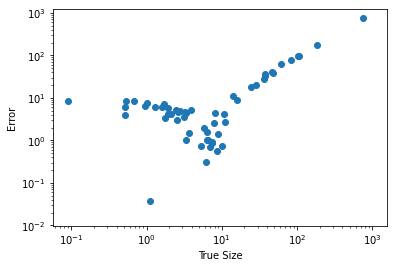

In [14]:
from sklearn import metrics

plt.scatter(y_test, abs(nnPredict - y_test))
# plt.plot([.1,20,1000],[.1,20,1000],c='k',linestyle='--')
plt.plot([.1,20,1000],[0,0,0],c='k',linestyle='--')
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')
plt.xlabel('True Size') 
plt.ylabel('Error')
print("nnPredict: ",mean_absolute_percentage_error(y_test, nnPredict), 'MAPE')

## Comparision between all 4 models

nnPredict:  372.865574914321 MAPE


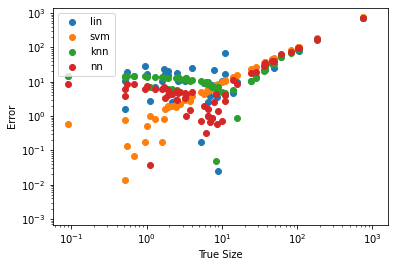

In [15]:
plt.scatter(y_test, abs(linPred - y_test))
plt.scatter(y_test, abs(svmPredict - y_test))
plt.scatter(y_test, abs(knnPredict - y_test))
plt.scatter(y_test, abs(nnPredict - y_test))

# plt.plot([.1,20,1000],[.1,20,1000],c='k',linestyle='--')
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')
plt.xlabel('True Size')
plt.ylabel('Error')
print("nnPredict: ",mean_absolute_percentage_error(y_test, nnPredict), 'MAPE')

plt.legend([ 'lin', 'svm', 'knn', 'nn' ])
plt.plot([.1,20,1000],[0,0,0],c='k',linestyle='--')